# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [5]:
display(data.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
display(data.duplicated().sum())

4

In [7]:
display(data.isna().mean())

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В нашем распоряжении датасет, состоящий из 16 колонок и 354369 строк. Имеются категориальные и количественные переменные. Много пропусков и есть полные дубликаты. Необходимо произвести преодбработку данных перед началом работы.

Обработаем пропущеннные значения:

In [8]:
display(data['VehicleType'].value_counts())
display(data['Gearbox'].value_counts())
display(data['Model'].value_counts())
display(data['FuelType'].value_counts())
display(data['Repaired'].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

no     247161
yes     36054
Name: Repaired, dtype: int64

In [9]:
# В столбце 'Model', 'VehicleType', 'FuelType' заполним пропуски как 'other'
data['Model'] = data['Model'].fillna('other')
data['VehicleType'] = data['Model'].fillna('other')
data['FuelType'] = data['Model'].fillna('other')

In [10]:
# В столбцe 'Repaired' заполним пропуски как 'yes' 
data['Repaired'] = data['Repaired'].fillna('no')

In [11]:
# В столбцe 'Gearbox',   заполним пропуски как 'unknown' 
data['Gearbox'] = data['Gearbox'].fillna('unknown')

In [12]:
display(data.isna().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [13]:
# Удалим дубликаты
data = data.drop_duplicates()

In [14]:
# Удалим стоблцы, информация в которых не влияет на наш целевой признак
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

In [15]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354363.000000,354363.000000,354363.000000,354363.000000,354363.000000
mean,4416.657351,2004.234483,110.093478,128211.311565,5.714643
std,4514.165941,90.228721,189.851802,37905.172769,3.726439
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


*Price*

<AxesSubplot:>

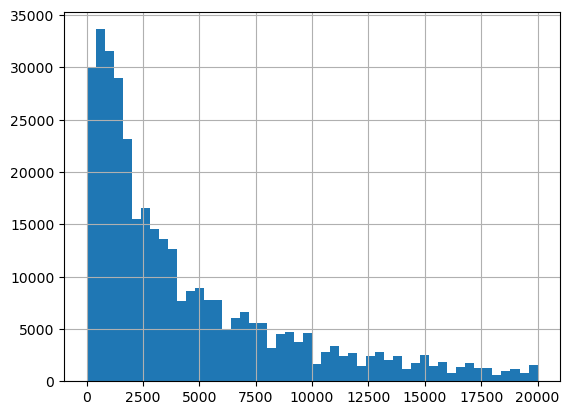

In [16]:
data['Price'].hist(bins=50)

<AxesSubplot:>

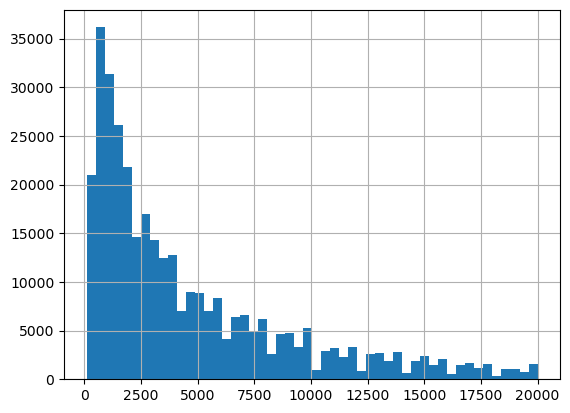

In [17]:
# Цена не может быть такой маленькой. Удалим значения меньше 100 и посмотрим еще раз на гистограмме.
data = data.query('Price > 100')
data['Price'].hist(bins=50)

*RegistrationYear*

In [18]:
print(sorted(data['RegistrationYear'].unique()))

[1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999]


In [19]:
# Очевидно, что разброс абсурдный. Ограничим минимальный год - 1960, а максимальный возьмем из max по DateCreated.
# print(data['DateCreated'].max())

data = data.query('1959 < RegistrationYear < 2017')

*Power*

In [20]:
print(sorted(data['Power'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

<AxesSubplot:>

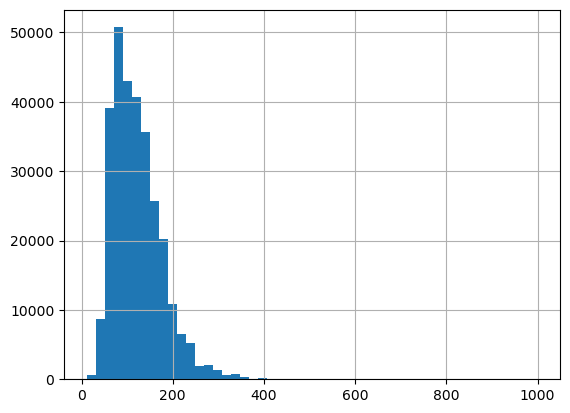

In [21]:
# Оставим мощность больше 10 и меньше 1000
data = data.query('10 < Power < 1001')
data['Power'].hist(bins=50)

*RegistrationMonth*

In [22]:
data['RegistrationMonth'].value_counts()

3     30313
6     27449
4     25649
5     25512
7     23726
10    22886
12    21118
11    20984
9     20886
1     20061
8     19655
2     18783
0     17459
Name: RegistrationMonth, dtype: int64

In [23]:
# Видим нулевой месяц. Удалим эти значения.
data = data.query('RegistrationMonth > 0')

## Анализ моделей

Обучим 3 модели ориентируясь на метрику RMSE. 
Модели: Случайный лес, LGBMRegressor, CatBoostRegressor.

Разделим данные на выборки: 

In [24]:
features = data.drop('Price', axis=1)
target = data['Price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=456)

In [25]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(207766, 10)
(69256, 10)
(207766,)
(69256,)


Закодируем категориальные признаки:

In [26]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)

In [27]:
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [28]:
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(207766, 790)
(69256, 784)


In [29]:
features_train_ohe, features_test_ohe = features_train_ohe.align(features_test_ohe, join='inner', axis=1)

In [30]:
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(207766, 784)
(69256, 784)


Напишем функцию для расчета RMSE:

In [31]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
myRMSE = make_scorer(RMSE, greater_is_better=False)

**Random forest**

In [32]:
%%time

rf = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [10, 20],
    'max_depth': list(range(1, 10, 3))
}
CV_rf = GridSearchCV(estimator=rf, param_grid=parameters, n_jobs=-1, verbose=3, cv=2, scoring='neg_root_mean_squared_error')
CV_rf.fit(features_train_ohe, target_train)
CV_rf_best_par = CV_rf.best_params_
CV_rf_best_score = CV_rf.best_score_
print(CV_rf_best_par, 'RMSE=', CV_rf_best_score*(-1))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
{'max_depth': 7, 'n_estimators': 20} RMSE= 2144.7736114300305
CPU times: user 39.6 s, sys: 1.82 s, total: 41.4 s
Wall time: 3min 6s


**CatBoostRegressor**

In [33]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'] 

In [34]:
%%time

cb = CatBoostRegressor(loss_function='RMSE')
parameters = {
    'depth':[5,10],
    'learning_rate': np.arange(0.1,1,0.3)
}
CV_cb = GridSearchCV(estimator=cb, param_grid=parameters, n_jobs=-1, verbose=2, cv=2, scoring='neg_root_mean_squared_error')
CV_cb.fit(features_train, target_train, cat_features=cat_features)
CV_cb_best_par = CV_cb.best_params_
CV_cb_best_score = CV_cb.best_score_
print(CV_cb_best_par, 'RMSE=', CV_cb_best_score*(-1))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ..max_depth=4, n_estimators=10;, score=-2605.345 total time= 1.6min
0:	learn: 4344.8272963	total: 270ms	remaining: 4m 30s
1:	learn: 4094.9111884	total: 425ms	remaining: 3m 31s
2:	learn: 3854.7736701	total: 647ms	remaining: 3m 35s
3:	learn: 3656.5536361	total: 810ms	remaining: 3m 21s
4:	learn: 3482.5847050	total: 1.1s	remaining: 3m 39s
5:	learn: 3323.1340987	total: 1.28s	remaining: 3m 32s
6:	learn: 3177.7160187	total: 1.52s	remaining: 3m 35s
7:	learn: 3054.5732931	total: 1.73s	remaining: 3m 35s
8:	learn: 2947.1912556	total: 1.86s	remaining: 3m 25s
9:	learn: 2849.7917988	total: 2.09s	remaining: 3m 27s
10:	learn: 2763.9591987	total: 2.43s	remaining: 3m 38s
11:	learn: 2686.7343714	total: 2.75s	remaining: 3m 46s
12:	learn: 2611.7189875	total: 3.06s	remaining: 3m 52s
13:	learn: 2547.3801694	total: 3.28s	remaining: 3m 51s
14:	learn: 2492.4223560	total: 3.54s	remaining: 3m 52s
15:	learn: 2443.0304554	total: 3.76s	remainin

**LGBMRegressor**

In [35]:
lgbm_features_train = features_train.copy()
lgbm_features_test = features_test.copy()

lgbm_features_train[cat_features] = features_train[cat_features].astype('category')
lgbm_features_test[cat_features] = features_test[cat_features].astype('category')

In [36]:
%%time

lgbm = LGBMRegressor() 
parameters = {
    'num_leaves':[31, 50],
    'learning_rate':[0.1, 0.3, 0.5]
}
CV_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters, n_jobs=-1, verbose=2, cv=2, scoring='neg_root_mean_squared_error')
CV_lgbm.fit(lgbm_features_train, target_train)
CV_lgbm_best_par = CV_lgbm.best_params_
CV_lgbm_best_score = CV_lgbm.best_score_
print(CV_lgbm_best_par, 'RMSE=', CV_lgbm_best_score*(-1))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
{'learning_rate': 0.3, 'num_leaves': 50} RMSE= 1657.8996162311014
CPU times: user 6.01 s, sys: 1.51 s, total: 7.52 s
Wall time: 10.5 s


Проверим все модели на тестовой выборке:

**RandomForest**

In [37]:
%%time

rf = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=7)
rf.fit(features_train_ohe, target_train)

CPU times: user 40.9 s, sys: 2.08 s, total: 43 s
Wall time: 3min 44s


RandomForestRegressor(max_depth=7, n_estimators=20, random_state=12345)

In [38]:
%%time

rf_predictions = rf.predict(features_test_ohe)
print('RandomForest RMSE:', mean_squared_error(target_test, rf_predictions, squared=False))

RandomForest RMSE: 2149.7436749395324
CPU times: user 211 ms, sys: 279 ms, total: 489 ms
Wall time: 822 ms


**CatBoostRegressor**

In [39]:
%%time

cb2 = CatBoostRegressor(loss_function='RMSE', learning_rate=0.1, depth=10, cat_features=cat_features)
cb2.fit(features_train, target_train)

0:	learn: 4304.2762975	total: 140ms	remaining: 2m 19s
1:	learn: 4009.8336471	total: 221ms	remaining: 1m 50s
2:	learn: 3745.6681768	total: 311ms	remaining: 1m 43s
3:	learn: 3512.0313743	total: 409ms	remaining: 1m 41s
4:	learn: 3311.7350308	total: 491ms	remaining: 1m 37s
5:	learn: 3131.6467267	total: 589ms	remaining: 1m 37s
6:	learn: 2975.0364485	total: 675ms	remaining: 1m 35s
7:	learn: 2833.0542122	total: 753ms	remaining: 1m 33s
8:	learn: 2707.7229438	total: 824ms	remaining: 1m 30s
9:	learn: 2594.6947071	total: 885ms	remaining: 1m 27s
10:	learn: 2500.9786954	total: 964ms	remaining: 1m 26s
11:	learn: 2415.4841202	total: 1.03s	remaining: 1m 24s
12:	learn: 2344.3457977	total: 1.08s	remaining: 1m 22s
13:	learn: 2279.9639290	total: 1.16s	remaining: 1m 21s
14:	learn: 2225.4698333	total: 1.23s	remaining: 1m 20s
15:	learn: 2177.2421048	total: 1.28s	remaining: 1m 19s
16:	learn: 2138.0985446	total: 1.34s	remaining: 1m 17s
17:	learn: 2101.8011033	total: 1.4s	remaining: 1m 16s
18:	learn: 2071.25948

In [40]:
%%time

cb_predictions = cb2.predict(features_test)
print('CatBoost RMSE:', mean_squared_error(target_test, cb_predictions, squared=False))

CatBoost RMSE: 1605.7103390615637
CPU times: user 917 ms, sys: 24 ms, total: 941 ms
Wall time: 191 ms


**LGBMRegressor**

In [41]:
%%time

lgbm = LGBMRegressor(num_leaves=50 , learning_rate=0.3)
lgbm.fit(lgbm_features_train, target_train)

CPU times: user 3.09 s, sys: 246 ms, total: 3.34 s
Wall time: 630 ms


LGBMRegressor(learning_rate=0.3, num_leaves=50)

In [42]:
%%time

lgbm_predictions = lgbm.predict(lgbm_features_test)
print('LGBMRegressor RMSE:', mean_squared_error(target_test, lgbm_predictions, squared=False))

LGBMRegressor RMSE: 1630.0200084721375
CPU times: user 540 ms, sys: 29.1 ms, total: 569 ms
Wall time: 76.7 ms


In [45]:
columns = ['Модель', 'Время обучения', 'Время предсказания', 'RMSE']
RandomForest = ['RandomForest', '3min 44s', '822 ms', 2149.74]
CatBoostRegressor = ['CatBoostRegressor', '1min 16s', '191 ms', 1605.71]
LGBMRegressor = ['LGBMRegressor', '630ms', '77 ms', 1630.02]

table = pd.DataFrame([RandomForest, CatBoostRegressor, LGBMRegressor], columns = columns)
display(table)

,Модель,Время обучения,Время предсказания,RMSE
0,RandomForest,3min 44s,822 ms,2149.74
1,CatBoostRegressor,1min 16s,191 ms,1605.71
2,LGBMRegressor,630ms,77 ms,1630.02


Лучшей моделью по качеству предсказания и времени обучения можно считать CatBoostRegressor.